# 1) Word Algebra with fastText (Italian)

This notebook demonstrates how to use static **fastText** embeddings
to solve lexical analogies of the form:

`king - man + woman → queen`

💡 **Prerequisites**  
1. Python 3.8+  
2. ~3 GB of free RAM (to load the 1.8 GB model)  
3. Internet connection to download the model once.


## Installing the *gensim* library


In [3]:
#!pip install gensim==4.3.2 -q

## Download the pre-trained Italian fastText model
# As exercise, try to find an english version

We will use the pre-trained Italian fastText embeddings released by Facebook.  
The command below uses `wget` with the `-c` option so that if the download is interrupted,
re-running it will automatically resume from where it left off.


In [6]:
#!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz

## Loading the model


In [9]:
import scipy, sys; print(scipy.__version__)

1.11.4


In [16]:
from gensim.models import KeyedVectors
import os

# CUSTOMIZE THE PATH to MATCH THE LOCATION WHERE YOUR MODEL IS
MODEL_PATH = '../../cc.it.300.vec.gz' 

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError('Model not found. Make sure the download has completed.')

print('⏳ Loading vectors… (this may take a few minutes)')
w2v = KeyedVectors.load_word2vec_format(MODEL_PATH, binary=False)
print(f'✅ Loaded {len(w2v):,} vocabulary entries.')


⏳ Loading vectors… (this may take a few minutes)
✅ Loaded 2,000,000 vocabulary entries.


## Utility function for analogies


In [18]:
def analyse(positives, negatives, topn=5):
    """check the vector comparison and returns the `topn` results."""
    results = w2v.most_similar(positive=positives,
                                 negative=negatives,
                                 topn=topn)
    for word, score in results:
        print(f"{word:12s}  simil: {score:.3f}")

### Example 1 — re - uomo + donna (king - man + woman)


In [24]:
analyse(['donna', 're'], ['uomo'])

Teuhe         simil: 0.549
regina        simil: 0.539
Puabi         simil: 0.478
Tyti          simil: 0.476
they'         simil: 0.463


### Example 2 — Paris - France + Italy (Paris - France + Italy)

(Paris - France + Italy)


In [28]:
analyse(['Parigi', 'Italia'], ['Francia'])


Milano        simil: 0.643
Londra        simil: 0.602
Roma          simil: 0.601
York          simil: 0.553
Bologna       simil: 0.551


### Example 3 — Hitler + Italy - Germany

(Hitler + Italy - Germany)


In [31]:
analyse(['Hitler', 'Italy'], ['Germany'], topn=5)


Mussolini     simil: 0.625
Duce          simil: 0.531
Stalin        simil: 0.491
Mussoli       simil: 0.485
Badoglio      simil: 0.480


In [35]:
# ============================================
# Reusable function to compare pairs
# ============================================
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def _unit(v):
    return v / np.linalg.norm(v)

def analyse_pairs(pairs, topn_diff=10, return_df=False):
    rows, diff_vectors = [], []

    for country, capital in pairs:
        v_cou = _unit(w2v[country])
        v_cap = _unit(w2v[capital])

        sim   = cosine_similarity([v_cou], [v_cap])[0, 0]
        dist  = 1 - sim
        rows.append((country, capital, sim, dist))
        diff_vectors.append(v_cap - v_cou)        # sono già normalizzati

    df = pd.DataFrame(rows, columns=["Country","Capital","sim_cos","distance"])
    display(df.style.format({"sim_cos":"{:.3f}", "distance":"{:.3f}"}))

    print("\nCosine Similarity between vectors:")
    for i, (p1, _) in enumerate(pairs):
        for j in range(i+1, len(pairs)):
            p2, _ = pairs[j]
            sim = cosine_similarity([diff_vectors[i]], [diff_vectors[j]])[0,0]
            print(f"{p1:10s} ↔ {p2:10s} : {sim:.3f}")

    if return_df:
        return df

In [37]:
pairs = [
    ("Happy", "Joyful"),
    ("Sad", "Unhappy"),
    ("Happy", "Unhappy"),
    ("Sad",  "Joyful"),
    ("Sad",  "Sad"),
]

pairs = [
    ("France",  "Paris"),
    ("Italy",   "Australopithecus"),
    ("Spain",   "Madrid"),
    ("Germany", "Berlin"),
]

analyse_pairs(pairs, topn_diff=10, return_df=False)


,Country,Capital,sim_cos,distance
0,France,Paris,0.506,0.494
1,Italy,Australopithecus,0.090,0.910
2,Spain,Madrid,0.458,0.542
3,Germany,Berlin,0.517,0.483



Cosine Similarity between vectors:
France     ↔ Italy      : 0.037
France     ↔ Spain      : 0.197
France     ↔ Germany    : 0.240
Italy      ↔ Spain      : 0.112
Italy      ↔ Germany    : 0.169
Spain      ↔ Germany    : 0.290


In [39]:
import sys, subprocess, importlib

def ensure_pkg(pkg, min_version=None):
    try:
        mod = importlib.import_module(pkg)
        if min_version and tuple(map(int, mod.__version__.split('.'))) < tuple(map(int, min_version.split('.'))):
            raise ImportError
    except ImportError:
        spec = f"{pkg}>={min_version}" if min_version else pkg
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", spec])

ensure_pkg("nbformat", "4.2.0")
ensure_pkg("plotly",   "5.19.0")   # se non l’avevi già

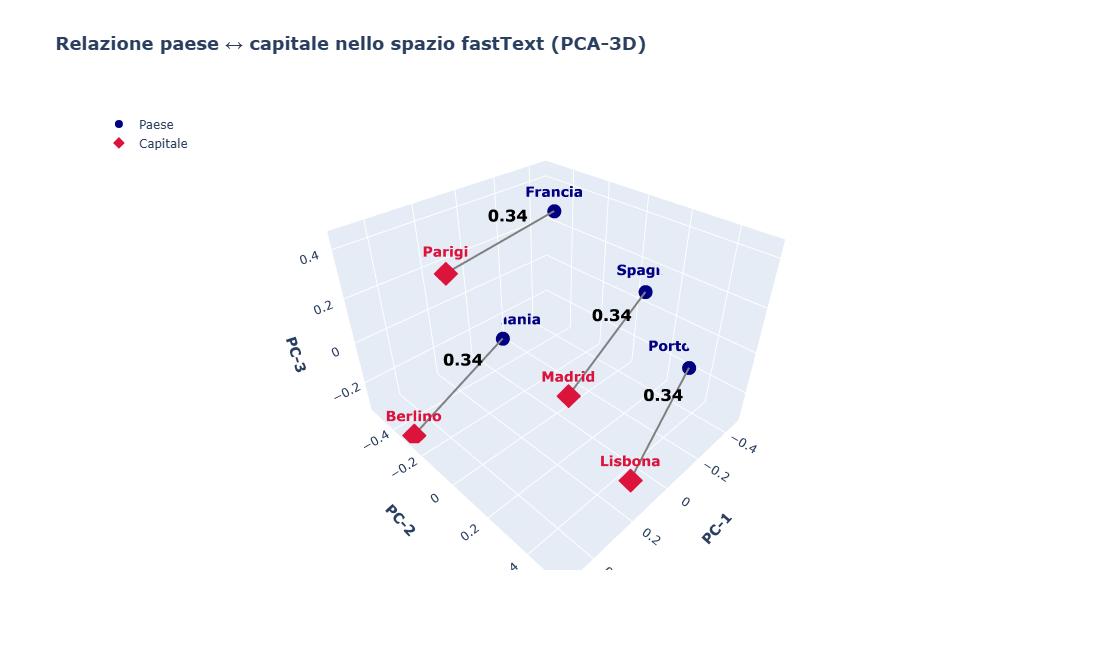

In [43]:
# ----------------------------------------------------------
# Interactive 3D Plot
# ----------------------------------------------------------
import sys, subprocess
try:
    import plotly.graph_objects as go
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "plotly>=5.19"])
    import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def plot_3d(
    pairs,
    figsize=(800, 650),
    font_size=14,
    line_width=4,
    marker_country=8,
    marker_capital=9
):
    # --------- vettori normalizzati ---------
    words = [w for p in pairs for w in p]
    vecs  = np.vstack([_unit(w2v[w]) for w in words])
    coords = PCA(n_components=3, random_state=42).fit_transform(vecs)
    coords_country = coords[0::2]
    coords_capital = coords[1::2]

    traces = []

    # --------- Paesi ----------
    traces.append(go.Scatter3d(
        x=coords_country[:,0], y=coords_country[:,1], z=coords_country[:,2],
        mode="markers+text",
        marker=dict(size=marker_country, color="navy"),
        text=[f"<b>{c}</b>" for c,_ in pairs],
        textposition="top center",
        textfont=dict(size=font_size, color="navy"),
        name="Paese"
    ))

    # --------- Capitali ----------
    traces.append(go.Scatter3d(
        x=coords_capital[:,0], y=coords_capital[:,1], z=coords_capital[:,2],
        mode="markers+text",
        marker=dict(size=marker_capital, color="crimson", symbol="diamond"),
        text=[f"<b>{cap}</b>" for _,cap in pairs],
        textposition="top center",
        textfont=dict(size=font_size, color="crimson"),
        name="Capitale"
    ))

    # --------- Segmenti + distanza ----------
    for i, (country, capital) in enumerate(pairs):
        x = [coords_country[i,0], coords_capital[i,0]]
        y = [coords_country[i,1], coords_capital[i,1]]
        z = [coords_country[i,2], coords_capital[i,2]]

        # linea
        traces.append(go.Scatter3d(
            x=x, y=y, z=z,
            mode="lines",
            line=dict(color="gray", width=line_width),
            showlegend=False
        ))

        # distanza coseno
        dist = 1 - cosine_similarity([_unit(w2v[country])],
                                     [_unit(w2v[capital])])[0,0]
        xm, ym, zm = np.mean(x), np.mean(y), np.mean(z)
        traces.append(go.Scatter3d(
            x=[xm], y=[ym], z=[zm],
            mode="text",
            text=[f"<b>{dist:.2f}</b>"],
            textfont=dict(size=font_size + 2, color="black"),
            showlegend=False
        ))

    # --------- helper titolo asse ----------
    def axis_title(txt):
        return dict(title=dict(text=f"<b>{txt}</b>",
                               font=dict(size=font_size)))

    # --------- Layout ----------
    layout = go.Layout(
        title=dict(text="<b>Relazione paese ↔ capitale nello spazio fastText (PCA-3D)</b>",
                   font=dict(size=18)),
        width=figsize[0], height=figsize[1],
        scene=dict(
            xaxis=axis_title("PC-1"),
            yaxis=axis_title("PC-2"),
            zaxis=axis_title("PC-3"),
            aspectmode="data"
        ),
        legend=dict(font=dict(size=font_size-2), x=0.02, y=0.98)
    )

    go.Figure(data=traces, layout=layout).show()


# ------------- ESEMPIO -------------
pairs = [
    ("Francia",  "Parigi"),
    ("Portogallo", "Lisbona"),
    ("Spagna",   "Madrid"),
    ("Germania", "Berlino")
]

plot_3d(pairs)



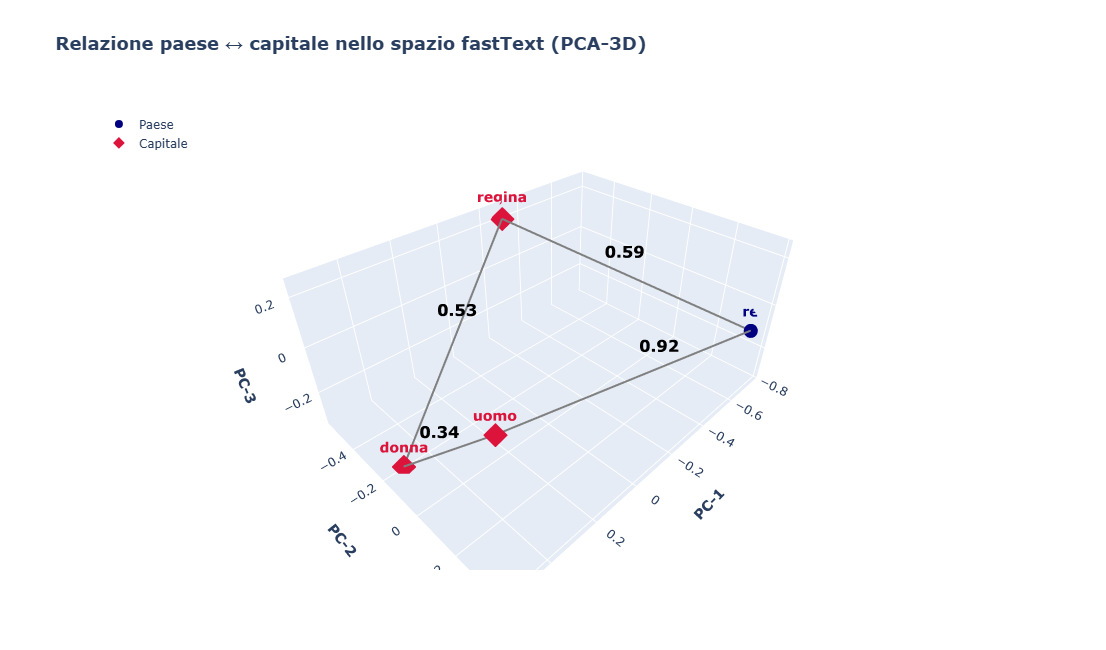

In [45]:
pairs = [
    ("re",  "uomo"),
    ("regina", "donna"),
    ("uomo", "donna"),
    ("re", "regina"),
   
]
plot_3d(pairs)


In [ ]:
pairs = [
    ("king",  "man"),
    ("queen", "woman"),
    ("man", "woman"),
    ("king", "queen"),
   
]
plot_3d(pairs)